In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import cv2
from tqdm import tqdm


from matplotlib.pyplot import imshow
import math
import json
import re
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from scipy.interpolate import griddata

/Users/aravjain/miniforge3/envs/spark_env/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/aravjain/miniforge3/envs/spark_env/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/aravjain/miniforge3/envs/spark_env/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Library/Frameworks/SentechSDK.framework/Versions/A/Libraries/libjpeg.9.dylib' (no such file), '/Library/Frameworks/SentechSDK.framework/Versions/A/Libraries/libjpeg.9.dylib' (no such file), '/libjpeg.9.dylib' (no such file), '/Users/aravjain/miniforge3/envs/spark_env/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/aravjain/miniforge3/envs/spark_env/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/aravjain/miniforge3/envs/spark_env/lib/python3.

In [2]:
def map_bscan_heatmaps_to_solid_circle(bscan_heatmaps, enface_image, pattern_type='foveal', 
                                      num_scans=None, smooth_factor=5, threshold=0.7, 
                                      center_radius_ratio=0.3):
    """
    Map B-scan heatmaps onto an enface image, creating a solid circular pattern
    
    Args:
        bscan_heatmaps: List of numpy arrays containing heatmaps from OCT B-scans
        enface_image: Numpy array of the enface image
        pattern_type: The scan pattern - 'foveal', 'raster', or 'radial'
        num_scans: Number of B-scans (if None, uses len(bscan_heatmaps))
        smooth_factor: Size of Gaussian kernel for final smoothing
        threshold: Value (0-1) to threshold the heatmap
        center_radius_ratio: Ratio of the image size to use for central circle mask
        
    Returns:
        The enface image with overlaid solid circular heatmap
    """
    # Make sure enface is RGB
    if len(enface_image.shape) == 2:
        enface_rgb = cv2.cvtColor(enface_image, cv2.COLOR_GRAY2RGB)
    else:
        enface_rgb = enface_image.copy()
    
    enface_rgb = enface_rgb.astype(np.uint8)
    h, w = enface_rgb.shape[:2]
    
    # If num_scans not provided, use length of heatmaps
    if num_scans is None:
        num_scans = len(bscan_heatmaps)
    
    # Initialize points and values for interpolation
    points = []
    values = []
    
    # Generate scan coordinates based on pattern type
    if pattern_type == 'foveal':
        # Foveal scan pattern (all B-scans pass through center/fovea)
        center_x, center_y = w // 2, h // 2
        
        # Distribute angles evenly
        angles = np.linspace(0, np.pi, num_scans)  # 180 degrees coverage
        
        for i, angle in enumerate(angles):
            if i >= len(bscan_heatmaps):
                break
                
            heatmap = bscan_heatmaps[i]
            
            # Calculate line endpoints (line passing through center)
            radius = min(w, h) // 2 - 5  # Slight margin from edge
            
            # Both ends of the line (passing through center)
            x1 = int(center_x + radius * np.cos(angle))
            y1 = int(center_y + radius * np.sin(angle))
            x2 = int(center_x - radius * np.cos(angle))
            y2 = int(center_y - radius * np.sin(angle))
            
            # Create the line
            line_mask = np.zeros((h, w), dtype=np.uint8)
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 1)
            line_y, line_x = np.where(line_mask > 0)
            
            # Skip if no points
            if len(line_x) == 0:
                continue
                
            # Resize heatmap to match line length
            num_points = len(line_x)
            resized_heatmap = cv2.resize(heatmap, (1, num_points), interpolation=cv2.INTER_LINEAR)
            
            # Add points and values
            for j, (x, y) in enumerate(zip(line_x, line_y)):
                if resized_heatmap[j, 0] > 0.05:  # Threshold for computation efficiency
                    points.append([x, y])
                    values.append(float(resized_heatmap[j, 0]))
    
    # Create grid for interpolation
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Check if we have enough points for interpolation
    if len(points) < 4:
        print("Warning: Not enough points for interpolation. Check your heatmaps.")
        return enface_rgb
    
    # Convert to numpy arrays with explicit dtype
    points = np.array(points, dtype=np.float32)
    values = np.array(values, dtype=np.float32)
    
    # Interpolate values onto the grid
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)
    grid_z = grid_z.astype(np.float32)
    
    # Smooth the result
    if smooth_factor > 0:
        grid_z = cv2.GaussianBlur(grid_z, (smooth_factor, smooth_factor), 0)
    
    # Normalize the heatmap
    if grid_z.max() > 0:
        grid_z = (grid_z - grid_z.min()) / (grid_z.max() - grid_z.min() + 1e-8)
    
    # Apply threshold to keep only bright regions
    grid_z[grid_z < threshold] = 0
    
    # Create a circular mask for the center region
    center_x, center_y = w // 2, h // 2
    center_mask = np.zeros_like(grid_z)
    radius = int(min(w, h) * center_radius_ratio)  # Adjust size of the circle
    cv2.circle(center_mask, (center_x, center_y), radius, 1, -1)
    
    # Apply the mask to keep only the central region
    grid_z = grid_z * center_mask
    
    # Convert to binary
    binary = (grid_z > 0).astype(np.uint8)
    
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    # Skip background (first component)
    if num_labels > 1:
        # Find component closest to center
        closest_component = 0
        min_dist = float('inf')
        
        for i in range(1, num_labels):
            comp_center_x, comp_center_y = centroids[i]
            dist = np.sqrt((comp_center_x - center_x)**2 + (comp_center_y - center_y)**2)
            
            if dist < min_dist:
                min_dist = dist
                closest_component = i
        
        # Create mask of only the central component
        central_mask = (labels == closest_component).astype(np.uint8)
        
        # Fill holes in the mask using morphological operations
        kernel = np.ones((5, 5), np.uint8)
        
        # Dilate to expand and fill small holes
        central_mask_dilated = cv2.dilate(central_mask, kernel, iterations=2)
        
        # Get convex hull to create a more regular shape without concavities
        contours, _ = cv2.findContours(central_mask_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 0:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Create a hull mask
            hull_mask = np.zeros_like(central_mask)
            hull = cv2.convexHull(largest_contour)
            cv2.drawContours(hull_mask, [hull], -1, 1, -1)
            
            # Create a perfectly circular mask based on the hull mask
            ellipse_mask = np.zeros_like(hull_mask)
            
            if hull.shape[0] >= 5:  # Need at least 5 points for ellipse fitting
                ellipse = cv2.fitEllipse(hull)
                cv2.ellipse(ellipse_mask, ellipse, 1, -1)
                
                # Use this mask for the final overlay
                final_mask = ellipse_mask.astype(np.float32)
            else:
                # If we don't have enough points for ellipse, just use the hull
                final_mask = hull_mask.astype(np.float32)
        else:
            # Fallback if no contours
            final_mask = central_mask_dilated.astype(np.float32)
        
        # Apply this mask to our grid_z to create a more uniform pattern
        grid_z = np.maximum(grid_z, final_mask * 0.7)  # Use 0.7 as a base intensity value
    
    # Apply colormap to create colored heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * grid_z), cv2.COLORMAP_HOT)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Create a mask for overlay (alpha channel)
    alpha_mask = (grid_z > 0).astype(np.float32)
    alpha_mask = cv2.GaussianBlur(alpha_mask, (5, 5), 0)  # Smooth the edges
    
    # Create result image
    result = np.copy(enface_rgb).astype(np.float32)
    
    # Only blend where the mask is non-zero
    for c in range(3):  # RGB channels
        result[:,:,c] = enface_rgb[:,:,c] * (1 - alpha_mask) + heatmap_colored[:,:,c] * alpha_mask
    
    # Convert back to uint8 for display and saving
    result = np.clip(result, 0, 255).astype(np.uint8)
    
    return result


In [3]:
def process_enface_solid_heatmap(heatmap_dir, enface_path, output_path=None, 
                               pattern_type='foveal', smooth_factor=5, threshold=0.7,
                               center_radius_ratio=0.3):
    """
    Complete pipeline to map B-scan heatmaps to enface image, creating a solid circular pattern
    
    Args:
        heatmap_dir: Directory containing heatmap images
        enface_path: Path to the enface image
        output_path: Path to save the result (optional)
        pattern_type: Scan pattern type ('foveal', 'raster', 'radial')
        smooth_factor: Size of Gaussian blur kernel for smoothing
        threshold: Value (0-1) to threshold the heatmap
        center_radius_ratio: Ratio of image size to use for central circle mask
        
    Returns:
        The resulting enface image with overlaid solid circular heatmap pattern
    """
    # Load heatmaps
    heatmap_files = sorted([f for f in os.listdir(heatmap_dir) 
                          if f.startswith('heatmap_') or f.endswith('.png') or f.endswith('.jpg')])
    
    bscan_heatmaps = []
    for heatmap_file in tqdm(heatmap_files, desc="Loading heatmaps"):
        path = os.path.join(heatmap_dir, heatmap_file)
        heatmap = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if heatmap is None:
            print(f"Warning: Could not load {path}")
            continue
            
        # Normalize
        heatmap = heatmap.astype(np.float32) / 255.0
        bscan_heatmaps.append(heatmap)
    
    print(f"Loaded {len(bscan_heatmaps)} heatmap images")
    
    if len(bscan_heatmaps) == 0:
        print("No heatmaps found. Check your directory.")
        return None
    
    # Load enface image
    enface_image = cv2.imread(enface_path)
    if enface_image is None:
        print(f"Could not load enface image: {enface_path}")
        return None
        
    enface_image = cv2.cvtColor(enface_image, cv2.COLOR_BGR2RGB)
    
    # Map heatmaps to enface, creating a solid circular pattern
    result = map_bscan_heatmaps_to_solid_circle(
        bscan_heatmaps, 
        enface_image, 
        pattern_type=pattern_type, 
        smooth_factor=smooth_factor,
        threshold=threshold,
        center_radius_ratio=center_radius_ratio
    )
    
    # Save if output path provided
    if output_path:
        # Create directory if it doesn't exist
        output_dir = os.path.dirname(output_path)
        if output_dir:  # Skip if it's just a filename with no directory
            os.makedirs(output_dir, exist_ok=True)
        
        # Make sure the file has a valid extension
        valid_extensions = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp']
        file_ext = os.path.splitext(output_path)[1].lower()
        
        if file_ext not in valid_extensions:
            # Default to PNG if extension is invalid
            output_path = output_path + '.png'
            print(f"Added .png extension to output path: {output_path}")
        
        # Save the image (convert RGB to BGR for OpenCV)
        cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        print(f"Saved result to: {output_path}")
    
    return result


Loading heatmaps: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 421.79it/s]


Loaded 6 heatmap images


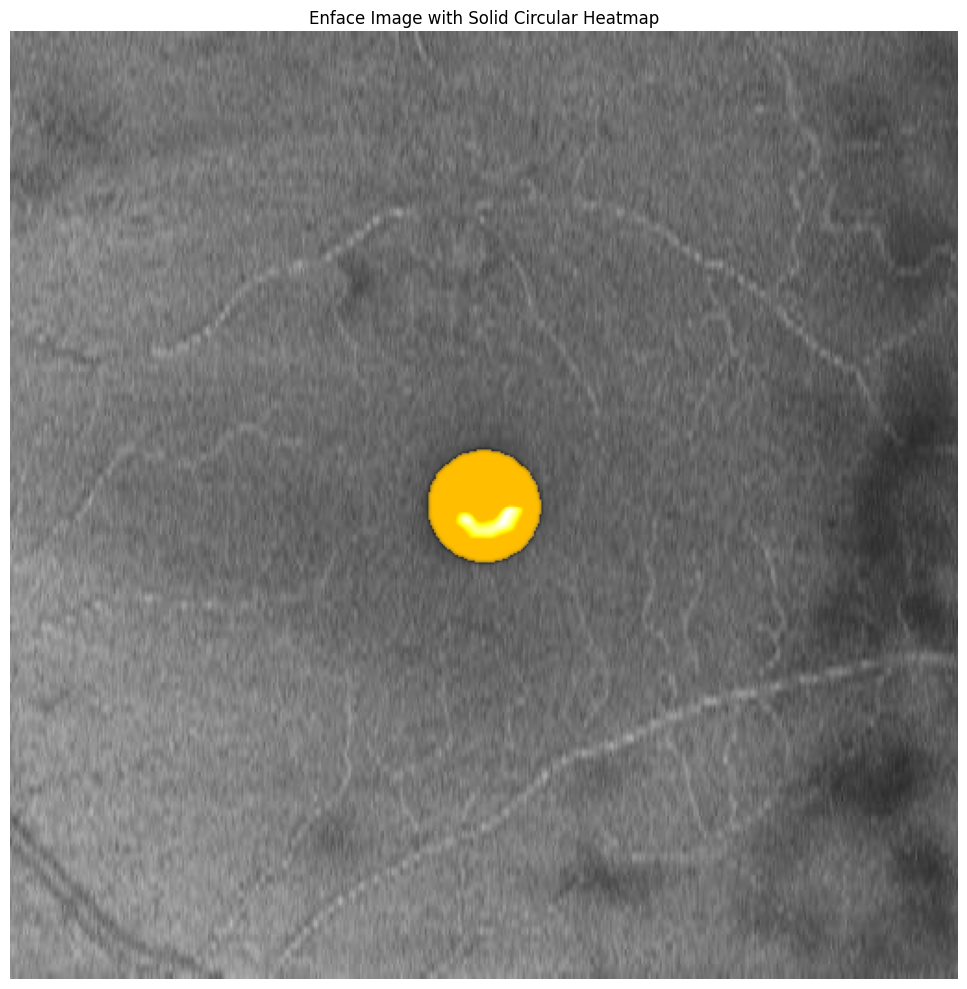

In [4]:
# Example usage
if __name__ == "__main__":
    # Example configuration
    heatmap_dir = "occ_masked_images"  # Directory with your heatmap images
    enface_path = "enface.jpg"  # Path to your enface image
    output_path = ""  # Where to save the result
    
    # Process with solid circular heatmap
    result = process_enface_solid_heatmap(
        heatmap_dir=heatmap_dir,
        enface_path=enface_path,
        output_path=output_path,
        pattern_type='foveal',
        smooth_factor=7,
        threshold=0.45,  # Adjust this value to control intensity threshold
        center_radius_ratio=0.05  # Adjust to control the size of the central circle
    )
    
    # Display result
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('Enface Image with Solid Circular Heatmap')
    plt.tight_layout()
    plt.show()